In [22]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [4]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Sat Jun  4 19:15:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!python bboxes_extractor.py --save-dir data/reference_images_part1_bboxes --dir-from /content/drive/MyDrive/data/reference_images_part1 --data-json /content/drive/MyDrive/data/reference_images_part1.json

In [13]:
!python bboxes_extractor.py --save-dir data/images_part1_valid_bboxes --dir-from /content/drive/MyDrive/data/images_part1_valid --data-json /content/drive/MyDrive/data/images_part1_valid.json

# Dataset

In [14]:
from typing import Optional, Callable, Tuple, Any
import numpy as np
from PIL import Image
import os


class MagicDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        img_dir: str,
        labels_file: Optional[str] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ) -> None:

        self.img_dir = img_dir
        self.labels_file = labels_file
        self.data = pd.read_csv(labels_file)
        self.img_names = self.data.loc[:, "filename"]
        self.img_labels = self.data.loc[:, "category_id"]

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_names)

    def __getitem__(self, index: int):
        img_path = os.path.join(self.img_dir, self.img_names[index])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[index]

        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)

        return image, label
    

In [15]:
IMG_DIR = './data/reference_images_part1_bboxes/images'
LABELS_FILE = './data/reference_images_part1_bboxes/bboxes_data.csv'
IMG_DIR_VAL = './data/images_part1_valid_bboxes/images'
LABELS_FILE_VAL = './data/images_part1_valid_bboxes/bboxes_data.csv'
BATCH_SIZE = 256

In [23]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [25]:
train_data = MagicDataset(img_dir=IMG_DIR, labels_file=LABELS_FILE, transform=transformations)
val_data = MagicDataset(img_dir=IMG_DIR_VAL, labels_file=LABELS_FILE_VAL, transform=transformations)

In [26]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean # unnormalize 
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

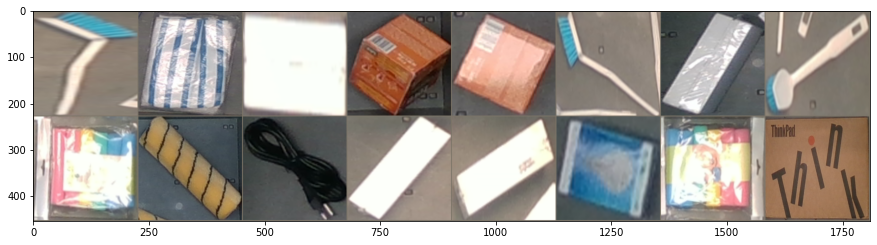

In [28]:
images, labels = next(iter(train_loader))

plt.rcParams['figure.figsize'] = 15, 10
imshow(torchvision.utils.make_grid(images[:16]))

# Model 

In [39]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model = torch.nn.Sequential(*(list(model.children())[:-1]), torch.nn.Flatten())

model = model.to(device)

In [41]:
model.eval()

EMBEDDING_SIZE = 2048
embeddings = torch.zeros((0, EMBEDDING_SIZE))
labels = torch.zeros((0))


with torch.no_grad():
    for ins, lbs in train_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels = torch.cat([labels.cpu(), lbs.cpu()])
        embeddings = torch.cat([embeddings.cpu(), model(ins).cpu()], dim=0)

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(embeddings.numpy(), labels.numpy())


KNeighborsClassifier(n_neighbors=3)

In [ ]:
labels_val = torch.zeros((0))
embeddings_val = torch.zeros((0, EMBEDDING_SIZE))

with torch.no_grad():
    for ins, lbs in val_loader:
        ins = ins.to(device)
        lbs = lbs.to(device)
        
        labels_val = torch.cat([labels_val.cpu(), lbs.cpu()])
        embeddings_val = torch.cat([embeddings_val.cpu(), model(ins).cpu()], dim=0)

In [ ]:
PATH_TO_SAVE = 'drive/data'

torch.save(labels_val, os.path.join(PATH_TO_SAVE, 'labels_val.pt'))
torch.save(embeddings_val, os.path.join(PATH_TO_SAVE, 'embeddings_val.pt'))

In [ ]:
embeddings_val.numpy().shape

In [ ]:
preds = knn.predict(embeddings_val.numpy())

In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(labels_val.numpy(), preds))